In [63]:
import copy
import os
import time
import torch.nn as nn
import numpy as np
import scipy.stats as st
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import utils
import tasks_sine, tasks_celebA
from cavia_model import CaviaModel
from active_model import Model_Active, Encoder_Decoder, Onehot_Encoder
from logger import Logger
import pickle

In [64]:
# Set seed
np.random.seed(5)
torch.manual_seed(5)

In [65]:
# Set hyperparameters
N_CONTEXT = 2
N_TASK = 1
N_BATCH_TRAIN = 10
N_BATCH_TEST = 100
MAX_ITER = 100
LR = 1
N_NEW_TASKS = 1000
NUM_STEPS = 20

In [66]:
# Load meta-trained model
# model = Model_Active(n_arch=[1,40,40,1],
#                      n_context=N_CONTEXT,
#                      gain_w=1,
#                      gain_b=1,
#                      device='cpu')
model = CaviaModel(n_in=1,
                   n_out=1,
                   num_context_params=2,
                   n_hidden=[40,40],
                   device='cpu')
logger = pickle.load(open('../loggers/logger_cavia_2context', 'rb'))
model.load_state_dict(logger.best_valid_model.state_dict())

<All keys matched successfully>

In [73]:
# Returns meta-test-train and meta-test-test losses after each 1..NUM_STEPS inner context update
def meta_test_loss_random_task(model, tasks, num_train=10, num_test=100, optim=torch.optim.SGD):
    criterion = nn.MSELoss()
    optimizer = optim([model.context_params], lr=LR)
    
    # Sample a random task and generate train & test data
    target_function = tasks.sample_tasks(num_tasks=1)[0]
    
    train_inputs = tasks.sample_inputs(N_BATCH_TRAIN)
    train_targets = target_function(train_inputs)
    
    test_inputs = tasks.sample_inputs(N_BATCH_TEST)
    test_targets = target_function(test_inputs)
    
    train_losses = []
    test_losses = []
    
    for step in range(NUM_STEPS):
        train_loss = criterion(model(train_inputs, model.context_params), train_targets)
        train_losses.append(train_loss.item())
        
        # Compute grad and update context params
        model.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        test_loss = criterion(model(test_inputs, model.context_params), test_targets)
        test_losses.append(test_loss.item())
    
    return train_losses, test_losses

In [74]:
sinusoid_tasks = tasks_sine.RegressionTasksSinusoidal()

total_train_losses = []
total_test_losses = []
avg_train_losses = []
avg_test_losses = []

# Collate meta test-train and meta test-test losses for new tasks
for t in range(N_NEW_TASKS):
    train_losses, test_losses = meta_test_loss_random_task(copy.deepcopy(model), sinusoid_tasks, num_train=N_BATCH_TRAIN, num_test=N_BATCH_TEST)
    total_train_losses.append(train_losses)
    total_test_losses.append(test_losses)
    
# Calculate average losses after each update
for i in range(NUM_STEPS):
    avg_train_loss = torch.mean(torch.tensor([l[i] for l in total_train_losses]).float())
    avg_test_loss = torch.mean(torch.tensor([l[i] for l in total_test_losses]).float())
    
    avg_train_losses.append(avg_train_loss)
    avg_test_losses.append(avg_test_loss)


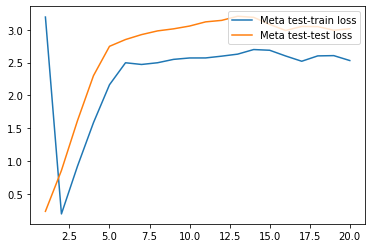

In [75]:
# Plot
# plt.scatter(list(range(1, NUM_STEPS+1)), avg_train_losses)
plt.plot(list(range(1, NUM_STEPS+1)), avg_train_losses, label='Meta test-train loss')
# plt.scatter(list(range(1, NUM_STEPS+1)), avg_test_losses)
plt.plot(list(range(1, NUM_STEPS+1)), avg_test_losses, label='Meta test-test loss')
plt.legend(loc='upper right')

(0, 1)

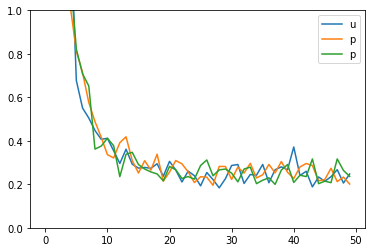

In [84]:
plt.plot(logger.train_loss, label='meta train-train')
plt.plot(logger.test_loss, label='meta train-test')
plt.plot(logger.valid_loss, label='meta train-valid')
plt.legend('upper right')
plt.ylim(0, 1)